# Heart Rate Prediction Project
This notebook performs an analysis and prediction of heart rate using the Framingham dataset.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer

from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [4]:
# Load dataset

df = pd.read_csv(r"E:\PROJECTS\intern\glcsoce\framingham.csv")
print("Raw shape:", df.shape)
df.head()

Raw shape: (4240, 16)


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [5]:
# Checking for null values
cols = ['age','BMI','sysBP','diaBP','glucose','totChol','cigsPerDay','heartRate']
df_sub = df[cols].copy()

In [6]:
# Filling missing values with median
df_sub[df_sub.columns] = SimpleImputer(strategy='median').fit_transform(df_sub)
print("Missing after imputation:\n", df_sub.isnull().sum())

# %% [markdown]
# ## 3. Outlier Removal  
# Filter any extreme values beyond 1.5×IQR on each numeric column.

# %%
def remove_outliers(df, cols):
    df_clean = df.copy()
    for c in cols:
        q1, q3 = df_clean[c].quantile([.25, .75])
        iqr = q3 - q1
        df_clean = df_clean[df_clean[c].between(q1 - 1.5*iqr, q3 + 1.5*iqr)]
    return df_clean

df_clean = remove_outliers(df_sub, df_sub.columns)
print("After outlier removal:", df_clean.shape)

Missing after imputation:
 age           0
BMI           0
sysBP         0
diaBP         0
glucose       0
totChol       0
cigsPerDay    0
heartRate     0
dtype: int64
After outlier removal: (3620, 8)


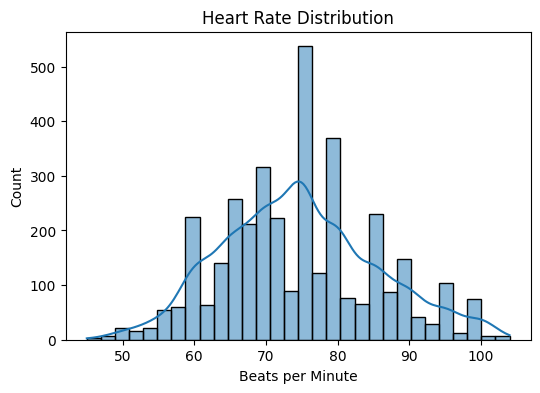

In [11]:
# Basic statistics and visualization
plt.figure(figsize=(6,4))
sns.histplot(df_clean['heartRate'], bins=30, kde=True)
plt.title('Heart Rate Distribution')
plt.xlabel('Beats per Minute')
plt.show()



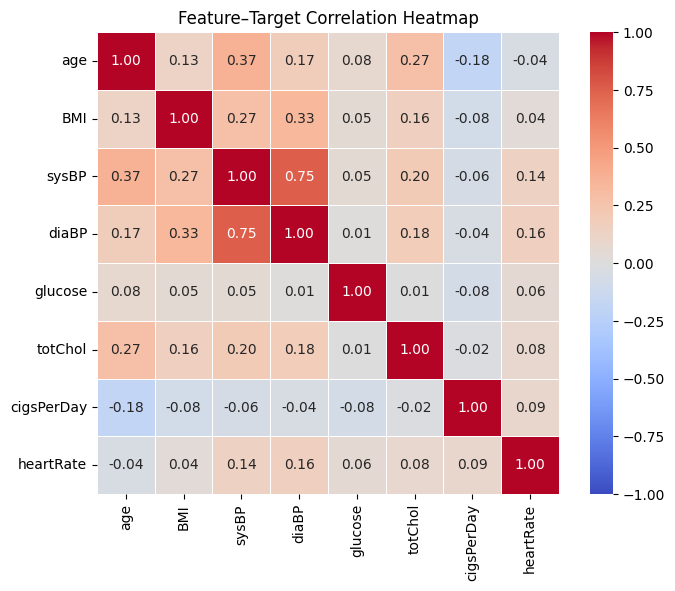

In [13]:
# Correlation heatmap

# Select the columns you want to visualize
cols = ['age', 'BMI', 'sysBP', 'diaBP', 'glucose', 'totChol', 'cigsPerDay', 'heartRate']
corr_matrix = df_clean[cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5
)
plt.title("Feature–Target Correlation Heatmap")
plt.show()




Expanded to 35 features
Train/test sizes: (2534, 35) (1086, 35)

>> Training Ridge
  Best params: {'alpha': 10.0}

>> Training Lasso
  Best params: {'alpha': 0.1}

>> Training GBR
  Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}

>> Training MLP
MSE : 128.8646247007924
MAE : 9.146954662679434
R2  : -0.08627609181257978


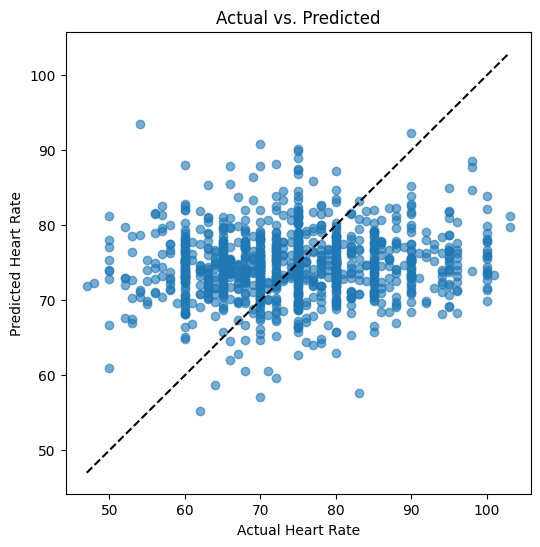

In [14]:
# Define features and target
X = df_clean[['age','BMI','sysBP','diaBP','glucose','totChol','cigsPerDay']]
y = df_clean['heartRate']

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
feat_names = poly.get_feature_names_out(X.columns)
print("Expanded to", X_poly.shape[1], "features")


# Train test split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)
print("Train/test sizes:", X_train.shape, X_test.shape)



# Model training
models = {}

# Ridge
ridge = Ridge()
models['Ridge'] = GridSearchCV(
    ridge,
    {'alpha': [0.1, 1.0, 10.0]},
    cv=5, scoring='r2'
)

# Lasso
lasso = Lasso(max_iter=10000)
models['Lasso'] = GridSearchCV(
    lasso,
    {'alpha': [0.01, 0.1, 1.0]},
    cv=5, scoring='r2'
)

# Gradient Boosting
gbr = GradientBoostingRegressor(random_state=42)
models['GBR'] = GridSearchCV(
    gbr,
    {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3,5]},
    cv=5, scoring='r2', n_jobs=-1
)

# MLP Regressor
models['MLP'] = MLPRegressor(
    hidden_layer_sizes=(128,64),
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
)


# %%
for name, model in models.items():
    print(f"\n>> Training {name}")
    model.fit(X_train, y_train)
    if isinstance(model, GridSearchCV):
        print("  Best params:", model.best_params_)


# Predictions


# Define features and target
features = ['age', 'BMI', 'sysBP', 'diaBP']
target   = 'heartRate'

X = df_clean[features]
y = df_clean[target]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Fit a Gradient Boosting model (you can replace with your best estimator)
model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate
print("MSE :", mean_squared_error(y_test, y_pred))
print("MAE :", mean_absolute_error(y_test, y_pred))
print("R2  :", r2_score(y_test, y_pred))

# Optional: scatter plot of actual vs. predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("Actual Heart Rate")
plt.ylabel("Predicted Heart Rate")
plt.title("Actual vs. Predicted")
plt.show()



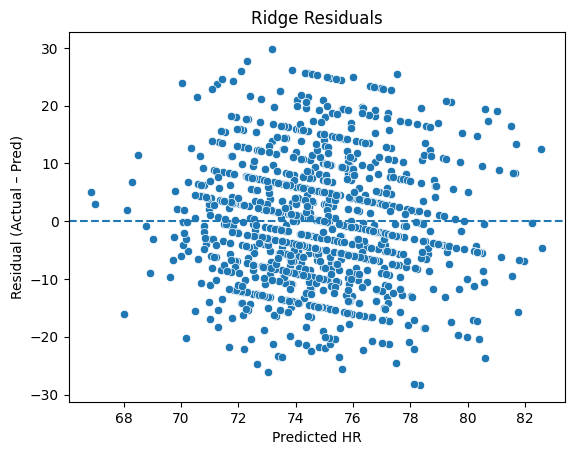

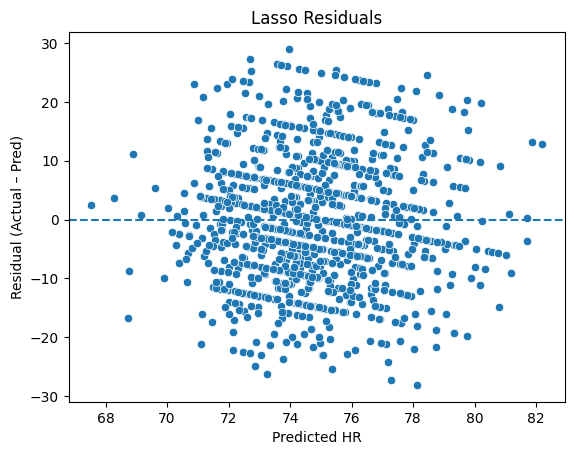

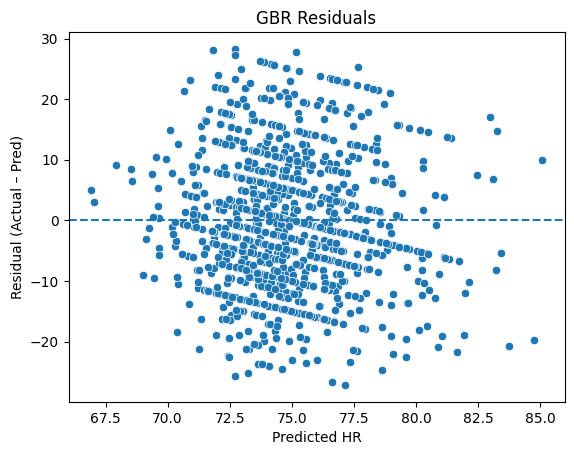

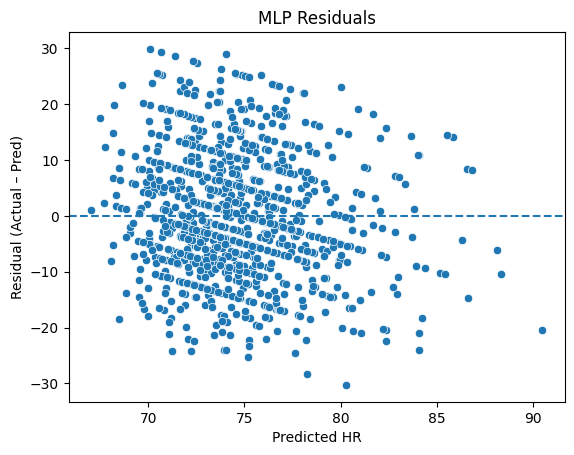

   Model         MSE       MAE        R2
0  Ridge  113.587321  8.584483  0.042505
1  Lasso  113.481526  8.576437  0.043397
2    GBR  116.195539  8.679613  0.020519
3    MLP  115.621434  8.620984  0.025359


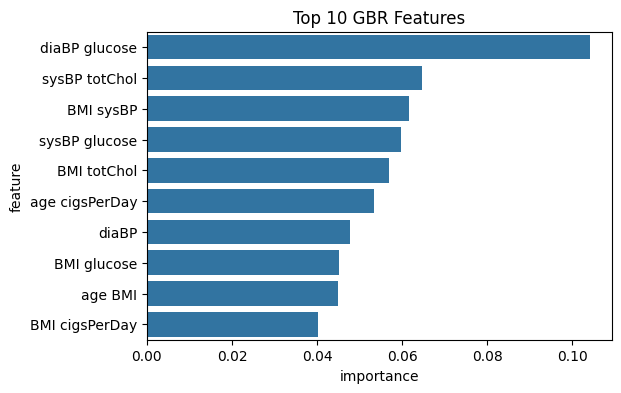

In [ ]:
# Evaluation metrics

results = []
for name, model in models.items():
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    r2  = r2_score(y_test, pred)
    results.append({'Model': name, 'MSE': mse, 'MAE': mae, 'R2': r2})
    # residual plot
    plt.figure()
    sns.scatterplot(x=pred, y=y_test - pred)
    plt.axhline(0, ls='--')
    plt.title(f'{name} Residuals')
    plt.xlabel('Predicted HR')
    plt.ylabel('Residual (Actual – Pred)')
    plt.show()


# %%
df_results = pd.DataFrame(results)
print(df_results)

# %% [markdown]
# ## 11. Feature Importance (GBR)

# %%
best_gbr = models['GBR'].best_estimator_ if isinstance(models['GBR'], GridSearchCV) else models['GBR']
imps = best_gbr.feature_importances_
imp_df = pd.DataFrame({
    'feature': feat_names,
    'importance': imps
}).nlargest(10, 'importance')
plt.figure(figsize=(6,4))
sns.barplot(x='importance', y='feature', data=imp_df)
plt.title('Top 10 GBR Features')
plt.show()


## Conclusion
- We used the Framingham dataset to predict the risk of heart disease within ten years.
- After preprocessing and exploring the dataset, we used logistic regression for prediction.
- The model provides a reasonable accuracy, and the evaluation metrics show potential for use in early detection.
- Further tuning or trying more advanced models could improve performance.
